In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [4]:
import cupy as cp

In [5]:
PROJECT_PATH = '../'
BLUE_PATH = "/scratch/ceph/szalay/swei20/AE/norm_flux_Blue_R2300.h5"
NIR_PATH = "/scratch/ceph/szalay/swei20/AE/norm_flux_NIR_R4300.h5"
sys.path.insert(0, PROJECT_PATH)

In [6]:
def collect_flux(nSample=10000, Rs=None):
    fluxs=[]
    pvals=[]
    lbls =[]
    if Rs is None: Rs = ["M31G", "MWW", "MWC", "BHB", "RHB"]
    for ii, R in enumerate(Rs):
        RBF_PATH = f"/scratch/ceph/swei20/data/dnn/{R}/rbf_RMLL_R500_10k.h5"
        with h5py.File(RBF_PATH, 'r') as f:
            flux0 = f['normflux'][()]
            pval0 = f['pval'][()]
            wave0 = f['wave'][()]
        fluxs.append(flux0[:nSample])
        pvals.append(pval0[:nSample])
        lbls.append(np.zeros(len(flux0)) + ii)
    fluxs = np.vstack(fluxs)
    pvals = np.vstack(pvals)
    lbls = np.hstack(lbls)
    lbln = [Rs[int(lbls[i])] for i in range(len(lbls))]    
    print(fluxs.shape, pvals.shape, lbls.shape)
    return fluxs, pvals, lbls, lbln, wave0

In [7]:
fluxs, pvals, lbls, lbln, wave0 = collect_flux()

(50000, 2204) (50000, 5) (50000,)


In [8]:
from lv.base.dataloader_c import DataLoader

In [9]:
ds = DataLoader()

In [10]:
ds.prepare_data_custom("RMLL", fluxs, wave0, pvals, lbl=lbln)

(50000, 2204) (2204,) (50000, 5)


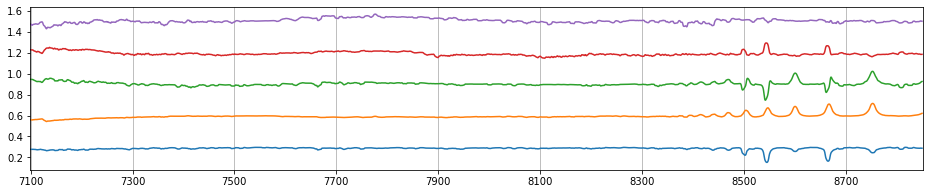

In [11]:
ds.init_pcp()

# Get informative lines

In [12]:
ds.prepare_lines()

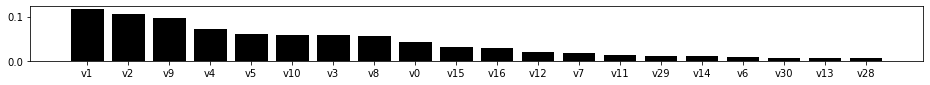

In [13]:
ds.get_X_cluster(data = 1)

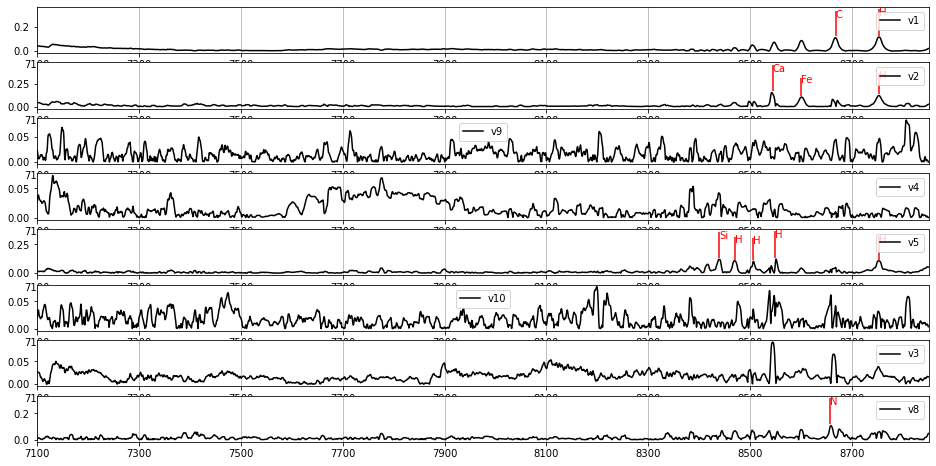

In [14]:
ds.plot_XdxAll(pcp=0, top=4, rfr=0)

In [27]:
ds.Cadx

array([  1,   2,   9,   4,   5,  10,   3,   8,   0,  15,  16,  12,   7,
        11,  29,  14,   6,  30,  13,  28,  17,  18,  35,  41,  34,  25,
        27,  38,  44,  26,  20,  53,  37,  42,  39,  24,  31,  55,  19,
        43,  21,  33,  32,  76,  52,  63,  59,  45,  22,  23, 116,  46,
       110,  97,  36,  69,  49,  57,  71, 129,  65,  48, 138, 169, 124,
        60,  66,  54,  75, 115,  62, 100, 127, 182,  40,  83, 133,  51,
       122,  77,  85, 162, 113,  72, 104,  70,  84,  67, 156,  58, 139,
        88, 193, 125,  78, 132, 184,  47, 106, 112,  56, 159, 126,  89,
       154, 151, 141, 103,  80, 194, 111, 199,  86,  81, 164, 185,  79,
       168, 176, 101,  91, 179,  96,  82, 160,  73,  61, 153, 167,  90,
       197, 174, 155,  99,  98, 130, 181, 165, 149, 144, 137, 120,  87,
       107,  68, 196, 119, 180, 135, 157, 134, 118, 148,  93, 198, 143,
       183, 158, 189, 121, 166, 163, 191, 173, 131, 161, 172, 102, 170,
       187, 195, 145,  92, 150, 136, 142, 146,  64, 178,  95, 14

In [26]:
len(ds.Cadx)

200

In [39]:
FluxC = ds.pcaFlux[:, ds.Cadx[:10]]

In [29]:
from cuml import UMAP

In [40]:
umap_dim = 5
u = UMAP(n_neighbors=1000, n_components=umap_dim)

In [41]:
uu = u.fit_transform(FluxC)

In [42]:
nuu = cp.asnumpy(uu)

In [43]:
dfumap = pd.DataFrame(data=nuu, columns = [f"u{i}" for i in range(umap_dim)])

In [44]:
# lbln = [RRs[int(lbls[i])] for i in range(len(lbls))]

In [45]:
dfumap["lbl"]=lbln

In [46]:
dfumap["lbl"].unique()

array(['M31G', 'MWW', 'MWC', 'BHB', 'RHB'], dtype=object)

In [47]:
import seaborn as sns

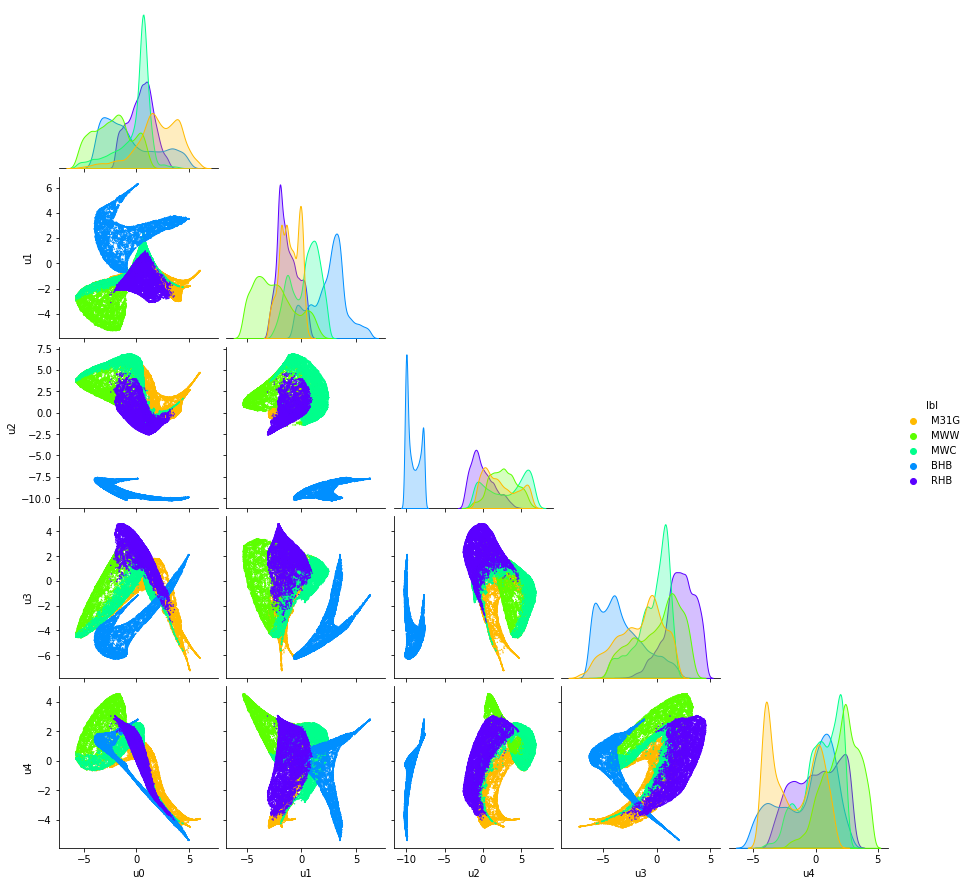

In [48]:
sns.pairplot(
    dfumap,
    x_vars = [f"u{i}" for i in range(umap_dim)],
    y_vars = [f"u{i}" for i in range(umap_dim)],
    hue = "lbl",
    plot_kws=dict(marker="o", s=2, edgecolor="none"),
    diag_kws=None,
    palette="gist_rainbow",
    corner=True
)